In [1]:
import os
import argparse
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, chi2_contingency
from scipy.stats.contingency import odds_ratio
from scipy import stats
from functools import reduce
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import sys
sys.path.append("../src")
import utils.parsing as utpa
import utils.plotting as utpl

# plotting
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
import forestplot as fp
import upsetplot

from scipy.stats import ttest_ind

In [2]:
def get_scaled_bmi(df, categorical_cols, numerical_cols, scaled_numerical_cols):
    # define encoders
    en = LabelEncoder()
    scaler = StandardScaler()
    # select the categorical and numerical columns
    # transform the categorical columns to integer values
    for cat_col in categorical_cols:
        df[cat_col] = en.fit_transform(df[cat_col])
    # scale the numerical columns
    df[numerical_cols] = scaler.fit_transform(df.loc[:, numerical_cols])
    # scale bmi separately
    df["bmi_scaled"] = scaler.fit_transform(df.loc[:, ["bmi"]])
    # Create the target variable (bmi_residuals) using linear regression
    X = df.loc[:, categorical_cols + numerical_cols + scaled_numerical_cols]
    y = df.loc[:, 'bmi_scaled']
    model = LinearRegression()
    model.fit(X, y)
    # save the residuals for bmi
    df['bmi_residuals'] = y - model.predict(X)
    return df


def create_bmi_res_prs_decile_data(phenotype_df, all_combo_samples):
    categorical_cols = ["genetic_sex"]
    numerical_cols = ["age"] + [f"genetic_pca{i}" for i in range(1, 40)]
    scaled_numerical_cols = []#["bmi_prs"]

    phenotype_df = get_scaled_bmi(phenotype_df, categorical_cols, numerical_cols, scaled_numerical_cols)
    phenotype_df["bmi_res_decile"] = pd.qcut(phenotype_df.bmi_residuals, q=10)
    phenotype_df["bmi_res_decile_num"] = pd.qcut(phenotype_df.bmi_residuals, q=10, labels=False)
    phenotype_df["bmi_prs_decile"] = pd.qcut(phenotype_df.bmi_prs, q=10)
    phenotype_df["bmi_prs_decile_num"] = pd.qcut(phenotype_df.bmi_prs, q=10, labels=False)
    phenotype_df["carrier"] = phenotype_df.sample_names.isin(all_combo_samples)
    phenotype_df["bmi_res_categories"] = phenotype_df.bmi_res_decile_num.map({
        0: "underweight", 
        1:"normal", 2:"normal", 
        3:"overweight", 4:"overweight", 5:"overweight", 6:"overweight", 7:"overweight",
        8:"obese", 9:"severe obesity"
        })
    phenotype_df["bmi_prs_categories"] = phenotype_df.bmi_prs_decile_num.map({
        0: "lowest", 
        1:"middle", 2:"middle", 
        3:"middle", 4:"middle", 5:"middle", 6:"middle", 7:"middle",
        8:"middle", 9:"highest"
        })
    mean_bmi_dict = phenotype_df.groupby("bmi_res_categories")["bmi"].mean().to_dict()
    return phenotype_df, mean_bmi_dict

In [3]:
cohort_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]

In [4]:
cohort_df = pd.read_csv(
    cohort_file, 
    usecols=["sample_names", "genetic_sex", "age"] + [f"genetic_pca{i}" for i in range(1, 40)] + ["bmi_prs", "bmi"])
cohort_df["sample_names"] = cohort_df.sample_names.astype(str)
combo_genes, combo_samples = utpa.get_combo_info_from_files(combo_files)

phenotype_samples_df, mean_bmi_dict = create_bmi_res_prs_decile_data(cohort_df, combo_samples)

# Comorbidities enriched in obese individuals

In [5]:
icd_raw_dir = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/icd_codes/data/icd_raw"
icd_codes_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/icd_codes/data/icd_tree/coding19.tsv"
hes_info_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/icd_codes/data/hes_info/hes_info.csv.gz"

In [6]:
icd_samples_df = utpa.create_icd_samples_file(icd_raw_dir)
icd_codes_df = pd.read_csv(icd_codes_file, usecols=["coding", "meaning", "node_id", "parent_id"], sep="\t")
icd_codes_df["coding"] = icd_codes_df.coding.str.replace(" ", "")
pheno_tree, root_pheno, c2nodeid_dict = utpa.create_tree(icd_codes_df, icd_samples_df)
hes_info_df = pd.read_csv(hes_info_file, dtype={"sample_names": str, "hes_info": float})
all_icd_samples = set(hes_info_df.loc[hes_info_df.hes_info>0, "sample_names"].values)
print(f"Samples in cohort {len(phenotype_samples_df)}")
phenotype_samples_df = phenotype_samples_df.loc[phenotype_samples_df.sample_names.isin(all_icd_samples)]
print(f"Samples with icd {len(phenotype_samples_df)}")
print(f"Samples with combo {len(combo_samples)}")
combo_samples = combo_samples.intersection(all_icd_samples)
print(f"Samples with combo and icd {len(combo_samples)}")

Samples in cohort 427639
Samples with icd 383253
Samples with combo 10193
Samples with combo and icd 9269


In [18]:
def get_table_icd(samples_of_interest, nonsamples_of_interest, comorbid_samples, field, shortlist):
    table = [
        [len(samples_of_interest.intersection(comorbid_samples)), len(samples_of_interest.difference(comorbid_samples))],
        [len(nonsamples_of_interest.intersection(comorbid_samples)), len(nonsamples_of_interest.difference(comorbid_samples))]
    ]
    df = pd.DataFrame(table, columns=[f"{field}", f"No {field}"], index=shortlist)
    return df

def get_icd_enrich(samples_of_interest, nonsamples_of_interest, all_cohort_samples, pheno_tree, icd_codes_df, c2nodeid_dict, shortlist, mode=""):
    icd_data = []

    for icdc in icd_codes_df.coding.values:
        icdc_node = pheno_tree.node_dict[c2nodeid_dict[icdc]]
        comorbid_samples = icdc_node.get_samples()
        comorbid_samples = all_cohort_samples.intersection(comorbid_samples)
        df = get_table_icd(samples_of_interest, nonsamples_of_interest, comorbid_samples, icdc_node.meaning, shortlist)
        res = fisher_exact(df)
        if mode=="lazy":
            or_study = res.statistic
            cil, cih = np.nan, np.nan        
        else:
            or_study = odds_ratio(df)
            cil, cih = or_study.confidence_interval(confidence_level=0.95)
        icdc_node_data = (icdc, icdc_node.meaning, df.iloc[0,0], df.iloc[0,1], df.iloc[1,0], df.iloc[1,1], or_study.statistic, res.pvalue, cil, cih)
        icd_data.append(icdc_node_data)
    
    icd_df = pd.DataFrame(icd_data, columns=["icd_code", "icd_meaning", f"{shortlist[0]}_comorbid", f"{shortlist[0]}_noncomorbid", f"{shortlist[1]}_comorbid", f"{shortlist[1]}_noncomorbid", "odds_ratio", "p_value", "ci_low", "ci_high"])
    icd_df["FDR"] = stats.false_discovery_control(icd_df.p_value)
    return icd_df

def get_level(icd_node, level):
    if icd_node.parent:
        return get_level(icd_node.parent, level+1)
    else:
        return level

def add_more_info(pheno_tree, code, odds, fdr, c2nodeid_dict):
    icd_node = pheno_tree.node_dict[c2nodeid_dict[code]]
    icd_node.fdr = fdr
    icd_node.odds = odds
    icd_node.level = get_level(icd_node, 0)
    return

def filter_icd_enrich(icd_df, pheno_tree, root_pheno, c2nodeid_dict):
    for num, row in icd_df.iterrows():
        code, odds, fdr = row.icd_code, row.odds_ratio, row.FDR
        add_more_info(pheno_tree, code, odds, fdr, c2nodeid_dict)
    root_pheno.fdr=1
    root_pheno.level=0
    root_pheno.odds=1

    df_columns = ["level", "node_id", "num_samples", "parent", "meaning", "coding", "fdr", "odds_ratio"]
    df_data_dict = {c:[] for c in df_columns}

    def save_data(curr_node):
        df_data_dict["level"].append(curr_node.level)
        df_data_dict["node_id"].append(curr_node.node)
        df_data_dict["num_samples"].append(len(curr_node.samples))
        if curr_node.parent:
            df_data_dict["parent"].append(curr_node.parent.meaning)
        else:
            df_data_dict["parent"].append("")
        df_data_dict["meaning"].append(curr_node.meaning)
        df_data_dict["coding"].append(curr_node.code)
        df_data_dict["fdr"].append(curr_node.fdr)
        df_data_dict["odds_ratio"].append(curr_node.odds)
        return

    def add_all_parents(curr_node, saved_nodes):
        if curr_node.parent:
            if curr_node.parent not in saved_nodes:
                save_data(curr_node.parent)
                saved_nodes.add(curr_node.parent)
                return add_all_parents(curr_node.parent, saved_nodes)
        return saved_nodes
    
    saved_nodes = set()
    for i,row in icd_df.loc[icd_df.FDR<0.05].iterrows():
        code = row.icd_code
        icd_node = pheno_tree.node_dict[c2nodeid_dict[code]]
        if icd_node not in saved_nodes:
            save_data(icd_node)
            saved_nodes.add(icd_node)
            saved_nodes.update(add_all_parents(icd_node, saved_nodes))

    # filter the phenotypes
    max_level=2
    df_data = pd.DataFrame(df_data_dict)
    df_data = df_data.loc[(df_data.level>0)&(df_data.level<max_level+1)].replace("Root Phenotype", "")
    df_data = df_data.loc[~((df_data.level==max_level)&(df_data.fdr>0.05))]
    df_data = df_data.loc[~(df_data.odds_ratio<1)]
    df_data["fdr_rank"] = df_data.fdr.rank()
    df_data["fdr_rank_inv"] = df_data.fdr_rank.apply(lambda x: 1/x)
    return df_data

In [19]:
obese_samples = set(phenotype_samples_df.loc[(phenotype_samples_df.bmi_res_categories=="severe obesity")|(phenotype_samples_df.bmi_res_categories=="obese"), "sample_names"].values)
notobese_samples = set(phenotype_samples_df.loc[(phenotype_samples_df.bmi_res_categories!="severe obesity")&(phenotype_samples_df.bmi_res_categories!="obese"), "sample_names"].values)
all_samples = set(phenotype_samples_df.sample_names.values)

In [20]:
len(all_samples), len(obese_samples), len(notobese_samples), len(obese_samples)+len(notobese_samples)

(383253, 79502, 303751, 383253)

In [21]:
icd_enrich_file = "/data6/deepro/ukb_bmi/3_characterization/data/pilot/obesity_icd_enrich.csv"
if not os.path.exists(icd_enrich_file):
    obese_samples_enrich_df = get_icd_enrich(obese_samples, notobese_samples, all_samples, pheno_tree, icd_codes_df, c2nodeid_dict, ["obese", "not obese"])
    obese_samples_enrich_df.to_csv(icd_enrich_file)
else:
    obese_samples_enrich_df = pd.read_csv(icd_enrich_file)

In [22]:
obesity_related_comorbid_df = filter_icd_enrich(obese_samples_enrich_df, pheno_tree, root_pheno, c2nodeid_dict)
obesity_related_comorbid_df = obesity_related_comorbid_df.loc[obesity_related_comorbid_df.level==2]
obesity_related_comorbid_df = obesity_related_comorbid_df.loc[~obesity_related_comorbid_df.meaning.str.lower().str.contains("obesity")] 
# eliminate external factors from ICD file: https://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=40001
obesity_related_comorbid_df = obesity_related_comorbid_df.loc[~obesity_related_comorbid_df.parent.str.startswith(("Chapter XV", "Chapter XX", "Chapter XXI"))]

In [23]:
len(obesity_related_comorbid_df)

121

# Cluster by icd comorbidities

In [25]:
def create_icd_comorbidity_features(icd_codes_of_interest, samples_of_interest, pheno_tree, c2nodeid_dict):
    icd_samples_data_dict = {"icd": [], "samples": []}
    for icd_code in icd_codes_of_interest:
        icd_node = pheno_tree.node_dict[c2nodeid_dict[icd_code]]
        comorbid_cohort_samples = samples_of_interest.intersection(icd_node.samples)
        icd_samples_data_dict["icd"].append(icd_node.code)
        icd_samples_data_dict["samples"].append(comorbid_cohort_samples)

    icd_samples_df = pd.DataFrame(icd_samples_data_dict)
    icd_samples_df = icd_samples_df.explode("samples")
    icd_samples_df = pd.crosstab(icd_samples_df.samples, icd_samples_df.icd)
    # ensure all samples are present
    existing_samples = set(icd_samples_df.index)
    no_comorbidity_samples = samples_of_interest.difference(existing_samples)
    if len(no_comorbidity_samples)>0:
        df_data = np.zeros((len(no_comorbidity_samples), icd_samples_df.shape[1]))
        no_comorbid_df = pd.DataFrame(df_data, index=list(no_comorbidity_samples), columns=icd_samples_df.columns)
        no_comorbid_df.index.name = icd_samples_df.index.name
        icd_samples_df = pd.concat((icd_samples_df, no_comorbid_df))
    return icd_samples_df

In [26]:
# creating a feature file for selected icd comorbidities
icd_codes_of_interest = set(obesity_related_comorbid_df.coding)
samples_of_interest = set(phenotype_samples_df.sample_names.values)
icd_features_df = create_icd_comorbidity_features(icd_codes_of_interest, samples_of_interest, pheno_tree, c2nodeid_dict)

In [70]:
def divide_into_nocomorbidity(features_df):
    no_comorbidity_df = features_df.loc[features_df.sum(axis=1)==0]
    comorbidity_df = features_df.loc[features_df.sum(axis=1)>0]
    return comorbidity_df, no_comorbidity_df

def find_the_best_cluster(X, nclusts=[2,3,4,5,6,7,8,9,10,15,25,50]):
    ds_scores = []
    for nclust in nclusts:
        kmeans = KMeans(n_clusters=nclust, random_state=42, n_init="auto")
        y = kmeans.fit_predict(X)
        dss = davies_bouldin_score(X, y)
        ds_scores.append(dss)
    ds_scores = np.array(ds_scores)
    print(ds_scores)
    return nclusts[np.argmin(ds_scores)]

# def cluster_by_comorbidity(train_features_df, test_features_df):
#     train_comorbidity_df, train_no_comorbidity_df = divide_into_nocomorbidity(train_features_df)
#     test_comorbidity_df, test_no_comorbidity_df = divide_into_nocomorbidity(test_features_df)
#     train_no_comorbidity_df["labels"] = 0
#     test_no_comorbidity_df["labels"] = 0
#     no_comorbidity_df = pd.concat((train_no_comorbidity_df, test_no_comorbidity_df))

#     X_train, X_test = train_comorbidity_df.values, test_comorbidity_df.values
#     nclust = find_the_best_cluster(X_train)
#     kmeans = KMeans(n_clusters=nclust, random_state=42, n_init="auto")
#     y_train = kmeans.fit_predict(X_train)
#     y_test = kmeans.fit_predict(X_test)
    
#     train_comorbidity_df["labels"] = y_train
#     test_comorbidity_df["labels"] = y_test
#     comorbidity_df = pd.concat((train_comorbidity_df, test_comorbidity_df))
#     comorbidity_df["labels"] = comorbidity_df.labels.replace(0, 2)
#     icd_df = pd.concat((comorbidity_df, no_comorbidity_df))
#     return icd_df.labels

def cluster_by_comorbidity_diff(features_df):
    comorbidity_df, no_comorbidity_df = divide_into_nocomorbidity(features_df)
    no_comorbidity_df["labels"] = 0

    X = comorbidity_df.values
    nclust = 2 #find_the_best_cluster(X)
    kmeans = KMeans(n_clusters=nclust, random_state=42, n_init="auto")
    y = kmeans.fit_predict(X)
    
    comorbidity_df["labels"] = y
    comorbidity_df["labels"] = comorbidity_df.labels.replace(0, nclust)
    icd_df = pd.concat((comorbidity_df, no_comorbidity_df))
    return icd_df.labels

def prepare_polynomial_features(data_df, features, y_var, include_bias):
    feature_df = data_df.loc[:, features].dropna()
    X = feature_df.values
    poly = PolynomialFeatures(len(features), interaction_only=True, include_bias=include_bias)
    X_poly = poly.fit_transform(X)
    y = data_df.loc[data_df.index.isin(feature_df.index), y_var].values.reshape(-1,1)
    return X_poly,y, poly.get_feature_names_out(input_features=features)[1:]

def train_model_sm(X, y):
    model = sm.OLS(y, X)
    results = model.fit()
    r2 = results.rsquared
    coefs = results.params[1:]
    conf_ints = results.conf_int()[1:]
    p_vals = results.pvalues[1:]
    return r2, coefs, conf_ints, p_vals

In [71]:
combo_features_df = icd_features_df.loc[icd_features_df.index.isin(combo_samples)]
noncombo_samples = all_samples.difference(combo_samples)
noncombo_features_df = icd_features_df.loc[icd_features_df.index.isin(noncombo_samples)]


# comorbidity_labels = cluster_by_comorbidity(noncombo_features_df, combo_features_df)
comorbidity_labels = cluster_by_comorbidity_diff(icd_features_df)

In [72]:
def get_average_comorbidity_per_label(icd_features_df, comorbidity_labels):
    ncomorbidity_df = icd_features_df.sum(axis=1).to_frame()
    ncomorbidity_df.columns = ["ncomorbidity"]
    ncomorbidity_df = ncomorbidity_df.merge(comorbidity_labels, left_index=True, right_index=True).groupby("labels")["ncomorbidity"].mean()
    avg_comorbidities_per_label = ncomorbidity_df.to_dict()
    return avg_comorbidities_per_label

def get_specific_comorbidity_enrichment_per_label(icd_features_df, comorbidity_labels):
    comorbidity_df, no_comorbidity_df = divide_into_nocomorbidity(icd_features_df)
    icd_data = []
    for icd_code in comorbidity_df.columns:
        df = comorbidity_df.loc[:, icd_code].to_frame().merge(comorbidity_labels, left_index=True, right_index=True).groupby("labels")[icd_code].value_counts().reset_index().pivot_table(index=icd_code, columns="labels", values="count")
        df = df.astype(int)
        assert df.index[0]==0
        res = fisher_exact(df)
        icdc_node_data = (icd_code, df.iloc[0,0], df.iloc[0,1], df.iloc[1,0], df.iloc[1,1], res.statistic, res.pvalue)
        icd_data.append(icdc_node_data)
    icd_df = pd.DataFrame(icd_data, columns=["icd_code", f"nocomorbidity_label1", f"nocomorbidity_label2", f"comorbidity_label1", f"comorbidity_label2", "odds_ratio", "p_value"])
    return icd_df

In [73]:
avg_comorbidity_per_group = get_average_comorbidity_per_label(icd_features_df, comorbidity_labels)

In [74]:
avg_comorbidity_per_group

{0: 0.0, 1: 3.8604604792455928, 2: 13.175010359729265}

In [75]:
comorbidity_labels = comorbidity_labels.map({0: "No", 1: "Medium", 2: "High"}).to_frame()
comorbidity_labels.columns = ["Comorbidity"]

In [76]:
cohort_df = phenotype_samples_df.loc[:, ["sample_names", "bmi", "bmi_prs", "bmi_residuals", "carrier", "bmi_res_categories", "bmi_prs_categories"]]

In [77]:
cohort_comorbid_df = cohort_df.merge(comorbidity_labels, left_on="sample_names", right_index=True)

In [78]:
cohort_comorbid_df.loc[(cohort_comorbid_df.carrier==True)&(cohort_comorbid_df.Comorbidity=="Medium")&(cohort_comorbid_df.bmi_prs_categories=="highest"),"bmi"].mean()

34.054307670614776

In [79]:
cohort_comorbid_df.loc[(cohort_comorbid_df.carrier==True)&(cohort_comorbid_df.Comorbidity=="High")&(cohort_comorbid_df.bmi_prs_categories=="highest"),"bmi"].mean()

36.12351118773946

In [80]:
def create_variate_interaction_plot(df, x="Comorbidity", y="bmi", order=["No", "Medium", "High"], hue="bmi_prs_categories", hue_order=["lowest", "middle", "highest"], height=6):
    g = sns.catplot(
        data=df, x=x, y=y, hue=hue, order=order, hue_order=hue_order, col="carrier",
        capsize=.2, palette="YlGnBu_d", errorbar="se",
        kind="point", height=height, aspect=.75,
    )
    for ax in g.axes.flatten():
        ax.grid()
    return g.figure

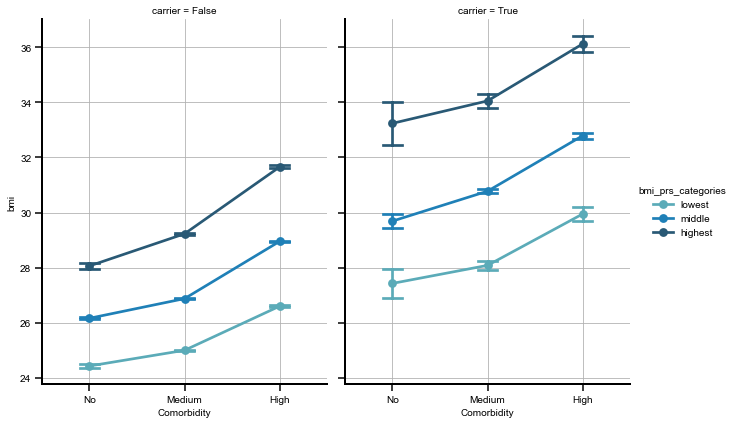

In [81]:
fig = create_variate_interaction_plot(cohort_comorbid_df)

In [82]:
def create_variate_interaction_model_plot(df, figsize=(6,3)):
    fig = fp.forestplot(
        df,  # the dataframe with results data
        estimate="coefs",  # col containing estimated effect size 
        ll="ci_low", hl="ci_high",
        pval="p_value",
        decimal_precision=3,
        varlabel="variables",  # column containing variable label
        color_alt_rows=True,
        table=True,
        annote=["est_ci"],
        annoteheaders=["Est. (95% Conf. Int.)"],
        # group ordering
        sort=True, # sort in ascending order (sorts within group if group is specified)
        ylabel="Est. (95% Conf. Int.)",  # y-label title
        xlabel="Model Coefficients",  # x-label title
        xticks=[-0.5, 0, 0.5, 1, 5],
        figsize=figsize,
        **{"marker": "D",  # set maker symbol as diamond
            "markersize": 75,  # adjust marker size
            "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
            "xlinecolor": "k",  # gray color for x-reference line
            "xline": 0,
            "xlinewidth": 1,
            "xtick_size": 12,  # adjust x-ticker fontsize
            "lw": 3,
            "thresholds": (0.001, 0.01, 0.05),
            }       
        )
    return fig.figure

def prepare_polynomial_features(data_df, features, y_var, include_bias):
    feature_df = data_df.loc[:, features].dropna()
    feature_df["Comorbidity"] = feature_df.Comorbidity.map({"No":0, "Medium":1, "High":2})
    X = feature_df.values
    poly = PolynomialFeatures(len(features), interaction_only=True, include_bias=include_bias)
    X_poly = poly.fit_transform(X)
    y = data_df.loc[data_df.index.isin(feature_df.index), y_var].values.reshape(-1,1)
    return X_poly,y, poly.get_feature_names_out(input_features=features)[1:]

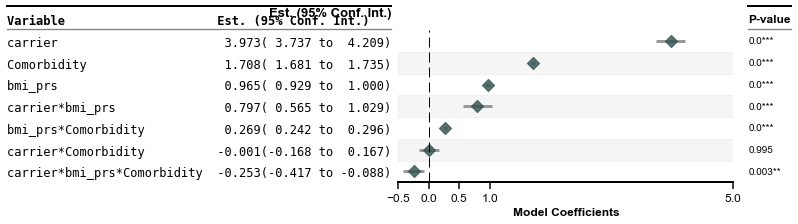

In [83]:
X_poly, y, poly_features = prepare_polynomial_features(cohort_comorbid_df, ["carrier", "bmi_prs", "Comorbidity"], "bmi", True)
r2, coefs, conf_ints, p_vals = train_model_sm(X_poly, y)
df_data = np.concatenate([poly_features.reshape(-1,1), coefs.reshape(-1,1), conf_ints, p_vals.reshape(-1,1)], axis=1)
coef_df = pd.DataFrame(df_data, columns=["variables", "coefs", "ci_low", "ci_high", "p_value"])
coef_df["variables"] = coef_df.variables.str.replace(" ", "*")
fig = create_variate_interaction_model_plot(coef_df)